# Finding the needle in the haystack: Identifying rare particles at the future Electron-Ion Collider

__Objective:__ Identify tau jets and separate them from hadron jets based on jet properties measured with an Electron-Ion Collider experiment.

High-energy particle colliders (like the future [Electron-Ion Collider](https://www.bnl.gov/bnlweb/pubaf/fact_sheet/pdf/EIC_Brochure.pdf) EIC) accelerate charged particles to nearly the speed of light. Two beams of particles are accelerated in opposite directions and then brought to collide with each other head-on. The collision of two particles (one from each beam) typically results in the creation of multiple other particles that fly away from the collision point.

Experiments at these colliders are essentially giant cameras with the goal to record the identity, energy, and direction of all the particles that come out of each collision. The experiments use different technologies to accomplish this. To measure direction, electric charge, and momentum of charged particles, they use a magnetic field that bends the path of charged particles depending on their charge and momentum, combined with a tracking detector that measures the particle trajectory. To measure the direction and energy of particles (charged or neutral), these experiments use so-called calorimeters. Calorimeters measure the energy of particles by stopping the particle (i.e. the particle deposits all its energy in the calorimeter) and returning a signal that is proportional to the deposited energy. If multiple particles can be grouped together based on the direction they are flying in, they are being considered a <a href="https://en.wikipedia.org/wiki/Jet_(particle_physics)">jet</a>. Different jet finding algorithms exist that apply differnt criteria for this grouping.

While many particles can be measured and identified directly, others decay so quickly that we can only measure their decay products. <a href="https://en.wikipedia.org/wiki/Tau_(particle)">Taus</a> are such quickly decaying particles. Even though we cannot detect them directly, we __can__ measure their decay products and use that information to identify the original tau.

The goal this study is to identify taus in Monte Carlo simulated EIC data. We focus on taus that decay into three charged [pions](https://en.wikipedia.org/wiki/Pion) (and a neutral pion and a neutrino, which escapes direct detection). These pions form a characteristically narrow and jet-like cone, which is typically narrower and contains fewer particles than the ubiquitous hadron jets. See the illustration below for a comparison between a typical hadron jet and a typical jet from a tau decaying into three charged pions. To identify taus, we need to find an effective way to distinguish tau jets from hadron jets.

<br>

<img src="figures/tau_signature.jpg" alt="Experimental signature of a tau lepton decaying into pions." style="width: 400px;"/>

The possibility to identify taus at the Electron-Ion Collider is exciting because it allows to search for the conversion of beam electrons into taus (which are heavier versions of electrons). Discovering such a conversion would significantly impact our understanding of nature. It is predicted by various theories of possible physics phenomena [beyond the Standard Model](https://en.wikipedia.org/wiki/Physics_beyond_the_Standard_Model). So far, no experiment has seen this conversion, and the EIC could potentially detect it. But, it is challenging to identify with certainty the rare electron-proton collisions in wich the electron turns into a tau. If they occur, they would constitute only one in 100 million events recorded at the EIC.

### The data
This analysis is performed on Monte Carlo simulated data for an EIC experiment. The data were generated in two steps:

1. Simulation of the __physics process__, i.e. the collision of an electron with a proton and the geneeration of all the particles coming out of this collision.
2. Simulation of the __detector response__ to the genreated particles, i.e. what could the a real EIC experiment actually measure and with what precision. This introduces uncertainties in the measurements that reflect the actual design of the experiment and its expected performance.

We use two input data files:
* `data/jets_lq_tau_3pi_r05_p250_e20.csv`: These are the signal events, i.e. the incoming electrons convert into taus, which subsequently decay into three charged pions.
* `data/jets_dis_cc_r05_p250_e20.csv`: These are background events. The electron converts into a neutrino that escapes detection, which is a process well described by the Standard Model.

Each row in the data files corresponds to an identified jet. Descriptions of the individual columns are given in `data/jets_column_description.xls`.

# 0 Preprocessing

Import libraries.

In [1]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

Set default matplotlib font. Define colors for matplotlib.

In [2]:
# set matplotlib font
font = {'family' : 'DejaVu sans',
        'weight' : 'normal',
        'size'   : 16}

matplotlib.rc('font', **font)

# define colors for matplotlib basen on Tableau10 Color blind palette
mycolors = [(0/256.,107/256.,164/256.),
            (255/256.,128/256.,14/256.),
            (171/256.,171/256.,171/256.),
            (89/256.,89/256.,89/256.),
            (95/256.,158/256.,209/256.),
            (200/256.,82/256.,0/256.)]

# 1 Reading and cleaning the data

Read simulated data for jets in events with (signal) and without (background) electron-to-tau conversion into Pandas dataframes. In addition to the jets actually coming from tau decays, the events in the signal sample also contain hadron jets, i.e. 'background'. Therefore, in the signal sample, we explicityl select and keep only those jets as signal which actually originate from a tau decay.

In [3]:
# read simulated data for electron-to-tau conversion
df_signal = pd.read_csv('data/jets_lq_tau_3pi_r05_p250_e20.csv')

# select only jets originating from a tau decay
df_signal = df_signal[ df_signal['evtgen_pid'] == 15]

# read data for background processes, i.e. electron does NOT convert to tau
df_background = pd.read_csv('data/jets_dis_cc_r05_p250_e20.csv')

Add 'signal' colum to each dataframe, where 'signal=1' for signal (tau) jets and 'signal=0' for background jets. This will be our __target column__. Afterwards, merge df_signal and df_background into df_combined for easier usage and print the total number of signal and background events in the data.

In [4]:
# add signal columns
df_signal['signal'] = 1
df_background['signal'] = 0

# merge datframes
df_combined = pd.concat([df_signal,df_background])

# count number of signal and background events in data
count_signal = len( df_combined[ df_combined['signal']==1 ] )
count_background =  len( df_combined[ df_combined['signal']==0 ] )

print( "Background events in data set: ", count_background )
print( "Signal events in data set:     ", count_signal )


Background events in data set:  8575
Signal events in data set:      7691


We need to drop some of the columns from the dataframe. The columns we drop are:
* columns with 'truth' information from the Monte Carlo simulation, i.e. columns containing information that a real experiment could not actually measure,
* columns that include information about the overall event beyond the properties of an individual jet,
* jetshpae_r90 and jetshpae_emcal_r90 because all values in those columns are 0.5 and 0.0, respectively, which hints that they were not filled properly, and
* Row, Instance, event, jet_id because they are event and jet identifiers but not measurements.

In [5]:
# columns with truth information
drop_columns_truth = ['is_lq_event','neutrino_pt','evtgen_pid','evtgen_ptotal','evtgen_etotal',
                       'evtgen_theta','evtgen_phi','evtgen_eta','evtgen_decay_prong','evtgen_decay_hcharged',
                       'evtgen_decay_lcharged']

# columns with overall event information
drop_columns_event = ['Et_miss','Et_miss_phi','reco_tau_eta',
                      'reco_tau_found','reco_tau_is_tau','reco_tau_phi','reco_tau_ptotal']

# more columns to drop because the values are not filled poperly or only used internally by simulation code 
drop_columns_var = ['Row','Instance','event','jet_id','jetshape_r90','jetshape_emcal_r90']

# drop these columns from dataframe
df_combined.drop( drop_columns_truth, axis=1, inplace=True )
df_combined.drop( drop_columns_event, axis=1, inplace=True )
df_combined.drop( drop_columns_var, axis=1, inplace=True )

Remove all rows with NAN entries. Print number of NAN in each column to confirm.

In [6]:
# drop rows with NAN
df_combined.dropna(inplace=True)

# print number of NAN values in each column
print( df_combined.isnull().sum() )

jet_eta                     0
jet_phi                     0
jet_etotal                  0
jet_etrans                  0
jet_ptotal                  0
jet_ptrans                  0
jet_minv                    0
jet_mtrans                  0
jet_ncomp                   0
jet_ncomp_above_0p1         0
jet_ncomp_above_1           0
jet_ncomp_above_10          0
jet_ncomp_emcal             0
jetshape_radius             0
jetshape_rms                0
jetshape_econe_r01          0
jetshape_econe_r02          0
jetshape_econe_r03          0
jetshape_econe_r04          0
jetshape_econe_r05          0
jetshape_emcal_radius       0
jetshape_emcal_rms          0
jetshape_emcal_econe_r01    0
jetshape_emcal_econe_r02    0
jetshape_emcal_econe_r03    0
jetshape_emcal_econe_r04    0
jetshape_emcal_econe_r05    0
tracks_count_r02            0
tracks_count_r04            0
tracks_count_R              0
tracks_rmax_r02             0
tracks_rmax_r04             0
tracks_rmax_R               0
tracks_cha

### Selecting only jets that match number of tracks for tau decays
As mentioned in the introduction, we are trying to specifically identify taus that decay into three charged pions. In addition, these taus need to have negative electric charge, because they converted from negatively charged electrons and electric charge has to be conserved. In other words, we are looking for jets that include exactly three charged tracks and the charges of those tracks add up to '-1'. The histograms below show the distribution of the __number of charged tracks (tracks_count_R)__ and the __sum of the charges of the charged tracks (tracks_chargesum_R)__ in signal and background jets of our data sample.

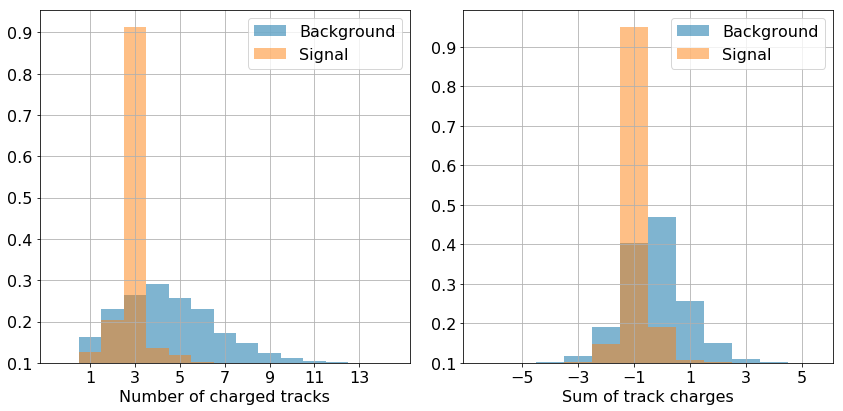

In [7]:
# quick way to plot histograms grouped by signal and background using the 'by' argument:
#df_combined.hist(column="tracks_count_R", by="signal", bins=50, color=mycolors[0], alpha=0.5)

# make nicer histograms
# create figure
plt.figure(figsize=(12,6))

# define bin ranges
bins_tracks_count = np.arange(-0.5,15.5,1)
bins_tracks_chargesum = np.arange(-6.5,6.5,1)

# force integer bin labels
xint_tracks_count = range(1,15,2)
xint_tracks_chargesum = range(-5,6,2)

# plot number of charged tracks and charge sum of all tracks in signal and background jets
# pass 'ax=ax' argument to histogram to plot it onto subfigure
# pass 'bottom' argument to histogram to allow for logarithmic axis with ax.set_yscale('log')
ax = plt.subplot(1,2,1)
df_combined[df_combined['signal']==0].hist("tracks_count_R", bottom=0.1, bins=bins_tracks_count, normed=1, ax=ax, color=mycolors[0], label='Background', alpha=0.5)
df_combined[df_combined['signal']==1].hist("tracks_count_R", bottom=0.1, bins=bins_tracks_count, normed=1, ax=ax, color=mycolors[1], label='Signal', alpha=0.5)
ax.set_title('')
ax.set_xlabel("Number of charged tracks")
ax.set_xticks(xint_tracks_count)
plt.legend(loc='upper right')


# plot charge sum of all tracks in signal and background jets
ax = plt.subplot(1,2,2)
df_combined[df_combined['signal']==0].hist("tracks_chargesum_R", bottom=0.1, bins=bins_tracks_chargesum, normed=1, ax=ax, color=mycolors[0], label='Background', alpha=0.5)
df_combined[df_combined['signal']==1].hist("tracks_chargesum_R", bottom=0.1, bins=bins_tracks_chargesum, normed=1, ax=ax, color=mycolors[1], label='Signal', alpha=0.5)
ax.set_title('')
ax.set_xlabel("Sum of track charges")
ax.set_xticks(xint_tracks_chargesum)
plt.legend(loc='upper right')

#tight layout
plt.tight_layout()

plt.show()

More than 90% of signal events show exactly 3 tracks with a chargesum of -1, as expected. However, some signal events do not. This is because the jet reconstruction algorithms uses data from realistic detector simulations as input. In other words, effects of tracks misidentification, missed tracks, and additional 'ghost' tracks are included. Just like in a real experiment.

We select only jets that have __between two and four charged tracks__ for further analysis. Some signal jets fall outside that range, which means we are loosing some overall efficiency for finding tau jets due to the performance of the simulated detector and the applied track and jet reconstruction algorithms. Improving these is a topic of ongoing studies and beyond the scope of this particular study.

In [8]:
# select only a subset of jets for further analysis that meets conditions on number of identified tracks
df_select = df_combined[ (df_combined['tracks_count_R']>=2)
                        &(df_combined['tracks_count_R']<=4) ].copy()

# count number of signal and background events in selected data
count_signal_select     = len( df_select[ df_select['signal']==1 ] )
count_background_select = len( df_select[ df_select['signal']==0 ] )

print( "Background events in selected data: %d (%.1f percent of all background jets)" %
      (count_background_select, 100*count_background_select/count_background) )
print( "Signal events in selected data: %d (%.1f percent of all signal jets)" %
      (count_signal_select, 100*count_signal_select/count_signal) )
print("")
print("With this selection, we keep \n %.1f percent of all signal (tau) jets and \n %.1f percent of all background (hadron) jets \nfor furhter analysis."
      % ( 100*count_signal_select/count_signal , 100*count_background_select/count_background ) )

Background events in selected data: 4035 (47.1 percent of all background jets)
Signal events in selected data: 7320 (95.2 percent of all signal jets)

With this selection, we keep 
 95.2 percent of all signal (tau) jets and 
 47.1 percent of all background (hadron) jets 
for furhter analysis.


We now have a data set with pre-selected jets that match tau decay jets in terms of the tracks. Next, we move on to look at more jet properties and engineering and selecting features that allow us to separate signal (tau) jets from background hadron) jets.

# 2 Feature engineering

### Radial jet energy distribution
The columns
* jetshape_econe_r01
* jetshape_econe_r02
* jetshape_econe_r03
* jetshape_econe_r04
* jetshape_econe_r05

all contain the energy found within a cone of different radii around the jet axis. The suffix indicates the cone size, with higher numbers corresponding to larger cone sizes. Therfore, for example, jetshape_econe_r04 includes all energy accounted for in the smaller cone jetshape_econe_r02. These columns are highly correlated with each other and the colum jet_etotal, which is the total energy associated with the jet, as shown in the following plots:

,jet_etotal,jetshape_econe_r01,jetshape_econe_r02,jetshape_econe_r03,jetshape_econe_r04,jetshape_econe_r05
jet_etotal,1.000000,0.864013,0.965118,0.989615,0.994800,0.988571
jetshape_econe_r01,0.864013,1.000000,0.929796,0.894224,0.869789,0.850396
jetshape_econe_r02,0.965118,0.929796,1.000000,0.984706,0.968579,0.952279
jetshape_econe_r03,0.989615,0.894224,0.984706,1.000000,0.992135,0.979802
jetshape_econe_r04,0.994800,0.869789,0.968579,0.992135,1.000000,0.993371
jetshape_econe_r05,0.988571,0.850396,0.952279,0.979802,0.993371,1.000000


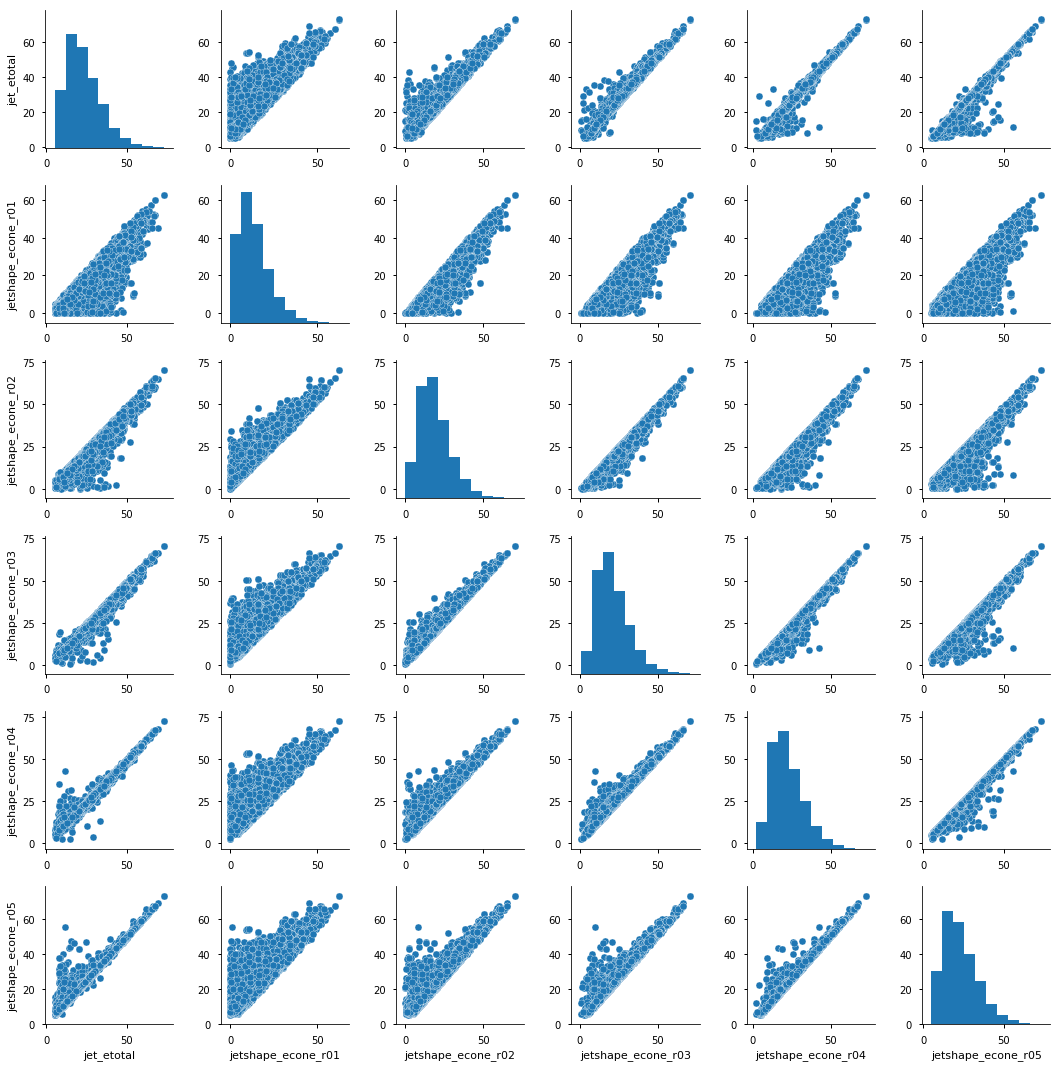

In [9]:
# array of columns to be checked for correlations
jetshape_econes = [
    'jet_etotal',
    'jetshape_econe_r01',
    'jetshape_econe_r02',
    'jetshape_econe_r03',
    'jetshape_econe_r04',
    'jetshape_econe_r05',
]

# plot pairwise correlations
with sns.plotting_context("notebook", font_scale=1.0, rc={"axes.axesbelow": False}):
    sns.pairplot( df_select[jetshape_econes] )
    
# print correlations table
df_select[jetshape_econes].corr()

Because of this correlation, we only use jet_etotal from this list for classifying signal (tau) jets. In addition, we  create a new variable which is the ratio between the energies measured in a small cone and the total jet energy. This variable relates to how the energy in the jet is distributed radially, i.e. if it is all concentrated close to the central axis or spread out across the size of the jet. For the narrower tau jets, we would expect the energy to be concentrated around the center of the jet.

,jet_etotal,jetshape_econe_r02,jetshape_econe_ratio
jet_etotal,1.000000,0.965118,0.328806
jetshape_econe_r02,0.965118,1.000000,0.531728
jetshape_econe_ratio,0.328806,0.531728,1.000000


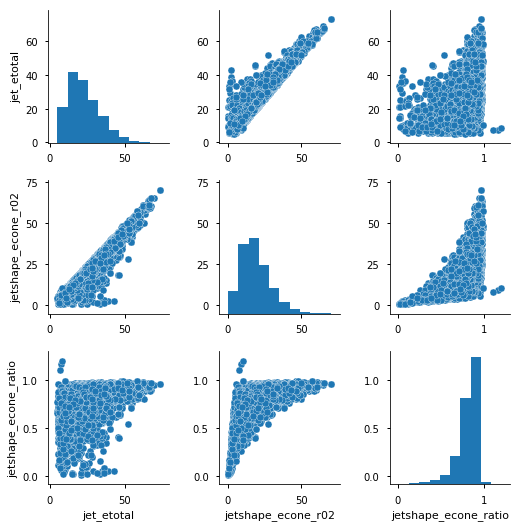

In [10]:
# create new variable jetshape_econe_ratio
df_select['jetshape_econe_ratio'] = df_select['jetshape_econe_r02'] / df_select['jet_etotal']

# plot correlations between jetshape_econe_r04, jetshape_econe_r02, and jetshape_econe_ratio
with sns.plotting_context("notebook", font_scale=1.0, rc={"axes.axesbelow": False}):
    sns.pairplot( df_select[['jet_etotal','jetshape_econe_r02','jetshape_econe_ratio']] )

df_select[['jet_etotal','jetshape_econe_r02','jetshape_econe_ratio']].corr()
# plot histogram for jetshape_econe_r04, jetshape_econe_r02, and jetshape_econe_ratio

The Pearson correlation factor between jetshape_econe_r04 and jetshape_econe_r02 is 0.97, while it is only 0.30 between jetshape_econe_r04 and jetshape_econe_ratio (the ratio jetshpae_econe_r02 / jetshpae_econe_r04). The newly created variable jetshape_econe_ratio seems like a good addition to the set of features we consider, so we keep it.

### Electromagnetic energy fraction
Similar to the columns we just looked at, the columns
* jetshape_emcal_econe_r01
* jetshape_emcal_econe_r02
* jetshape_emcal_econe_r03
* jetshape_emcal_econe_r04
* jetshape_emcal_econe_r05

containe the energy measured in the elctromagnetic calorimeter (one specific subsystem to measure particle energies) within cones of different radii around the jet axis. This energy is included in the jetshape_econe variables, so again there is a high correltion and we can reduce this cirrelation by defining a ratio variable __jetshape_emratio__. The fraction of energy deposited in the electromagnetic calorimeter is a measure of the electromagnetic content of the jet, in other words it again gives more information that just a single energy measurement by itself. So we add __jetshape_emratio__ to our feature columns.

In [11]:
# define new ratio column
df_select['jetshape_emratio'] = df_select['jetshape_emcal_econe_r02'] / df_select['jetshape_econe_r02']

df_select[['jetshape_emcal_econe_r02','jetshape_econe_r02','jetshape_emratio']].corr()

,jetshape_emcal_econe_r02,jetshape_econe_r02,jetshape_emratio
jetshape_emcal_econe_r02,1.000000,0.761743,0.678009
jetshape_econe_r02,0.761743,1.000000,0.150657
jetshape_emratio,0.678009,0.150657,1.000000


# 3 Establishing a baseline for tau identification with a cut based selection

Ee choose a few of the feature columns and apply cuts to select signal (tau) jets from the combined sample of signal and background (hadron) jets. The efficiency and purity of these cuts will give us a baseline for training and testing machine learning algorithms so separate signal (tau) jets from background (hadron) jets.

Plot the distributions of the feature columsn used for cut based selection of tau (signal) events for the signal and background events. Vertical green lines indicate the thresholds for cuts.

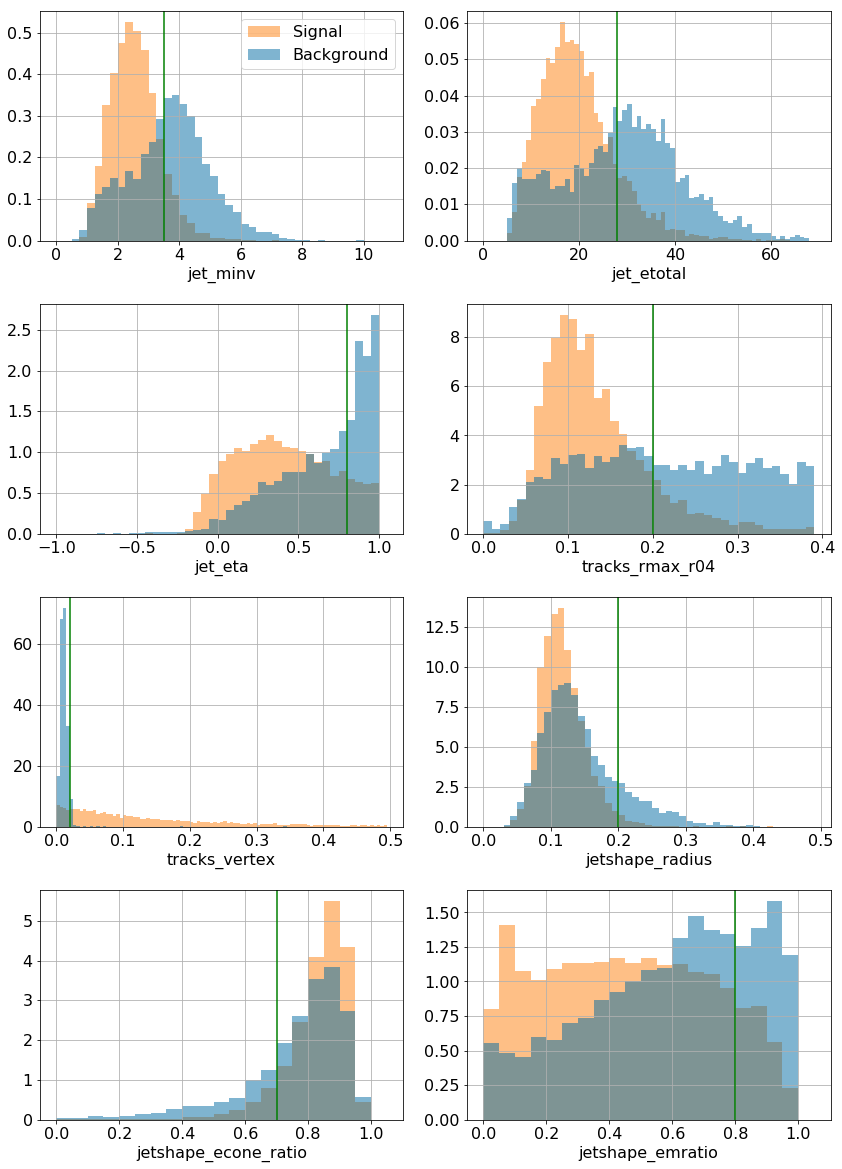

In [12]:
# list of features for cut based selection
cut_cols = ['jet_minv', 'jet_etotal', 'jet_eta',
            'tracks_rmax_r04', 'tracks_vertex', 'jetshape_radius',
            'jetshape_econe_ratio', 'jetshape_emratio']

# define bins for each feature
plot_bins = [np.arange(0,11,0.25), np.arange(0,70,1), np.arange(-1,1.1,0.05),
             np.arange(0,0.4,0.01), np.arange(0,0.5,0.005), np.arange(0,0.5,0.01),
             np.arange(0,1.1,0.05), np.arange(0,1.1,0.05)]

# define thresholds for signal (tau) selection
cut_thresholds = [3.5, 28, 0.8,
                  0.2, 0.02, 0.2,
                  0.7, 0.8]

# create figure
plt.figure(figsize=(12,20))

# plot signal and background histograms for each feature
for idx, col_i in enumerate( cut_cols ):    
    ax = plt.subplot(5,2,idx+1)
    df_select[df_select['signal']==1].hist(col_i, bins=plot_bins[idx], ax=ax,
                                               normed=True, color=mycolors[1], label='Signal', alpha=0.5)
    df_select[df_select['signal']==0].hist(col_i, bins=plot_bins[idx], ax=ax,
                                               normed=True, color=mycolors[0], label='Background', alpha=0.5)
    ax.set_title('')
    ax.set_xlabel(col_i)
    
    # plot line for cut threshold
    plt.axvline(x=cut_thresholds[idx], color='green')
    
    # only plot legend in first subfigure
    if ( idx == 0 ):
        plt.legend(loc='upper right')

#tight layout
plt.tight_layout()
plt.show()

In [13]:
# apply manual cuts to dataframe
df_cut = df_select[( df_select['jet_minv'] < cut_thresholds[0] ) &
                   ( df_select['jet_etotal'] < cut_thresholds[1] ) &
                   ( df_select['jet_eta'] < cut_thresholds[2] ) &
                   ( df_select['tracks_rmax_r04'] < cut_thresholds[3] ) &
                   ( df_select['tracks_vertex'] > cut_thresholds[4] ) &
                   ( df_select['jetshape_radius'] < cut_thresholds[5] ) &
                   ( df_select['jetshape_econe_ratio'] > cut_thresholds[6] ) &
                   ( df_select['jetshape_emratio'] < cut_thresholds[7] )
                  ]

# count background and signal jets left after cut
background_select_cut = len( df_cut[ df_cut['signal'] == 0 ] )
signal_select_cut = len( df_cut[ df_cut['signal'] == 1 ] )

print( "True positives (signal events in selected data after applying manual cuts):\n %d (%.1f percent of all signal jets)" %
      (signal_select_cut, 100*signal_select_cut/count_signal_select) )

print( "False positives (background events in selected data after applying manual cuts):\n %d (%.1f percent of all background jets)" %
      (background_select_cut, 100*background_select_cut/count_background_select) )


True positives (signal events in selected data after applying manual cuts):
 3352 (45.8 percent of all signal jets)
False positives (background events in selected data after applying manual cuts):
 9 (0.2 percent of all background jets)


After applying the set of manual cuts defined above, 45.8% of the true signal events are identified as signal events (true positives), while only 0.2% of background jets pass this cut (false positives).

From the histograms above, it looks like the track_vertex cut provides the strongest separation between signal (tau) and background (hadron) jets. Let's see what the cut only on this feature yields:

In [14]:
# apply manual cuts to dataframe
df_cut_vertex = df_select[ df_select['tracks_vertex'] > cut_thresholds[4] ]

# count background and signal jets left after cut
background_select_cut_vertex = len( df_cut_vertex[ df_cut_vertex['signal'] == 0 ] )
signal_select_cut_vertex = len( df_cut_vertex[ df_cut_vertex['signal'] == 1 ] )

print( "True positives (signal events in selected data after applying only vertex cut):\n %d (%.1f percent of all signal jets)" %
      (signal_select_cut_vertex, 100*signal_select_cut_vertex/count_signal_select) )

print( "False positives (background events in selected data after applying only vertex cut):\n %d (%.1f percent of all background jets)" %
      (background_select_cut_vertex, 100*background_select_cut_vertex/count_background_select) )

True positives (signal events in selected data after applying only vertex cut):
 6460 (88.3 percent of all signal jets)
False positives (background events in selected data after applying only vertex cut):
 235 (5.8 percent of all background jets)


As we suspected, this cut alone removes most of the background jets, leaving only 5.8% false positives and 88.3% true positives. While a high true positives rate is important when looking for rare events in data at the Electron-Ion Collider, a low false positive rate is actually much more critical. As mentioned in the introduction, the models for the process we are looking for predict that the background events will be more than 100 million times more abundant than the signal events.

In the next section, we will see how using machine learning algorithms can improve the true positive and false positive rates for identifying signal (tau) jets in our simulated data.

# 4 Training algorithm for tau jet classification

### Splitting data into train and test sample

Splitting the data into one data set for training and one for testing machine learning algorithms for tau classification:

In [15]:
# create a random mask to select events from dataframes
msk = np.random.rand( len(df_select) ) < 0.6

# use mask to select events for training dataframe and complimentary test dataframe
df_train = df_select[msk]
df_test = df_select[~msk]

print( "Background events in training set: ", len( df_train[ df_train['signal']==0 ] ) )
print( "Signal events in training set:     ", len( df_train[ df_train['signal']==1 ] ) )
print( "Background events in testing set:  ", len( df_test[ df_test['signal']==0 ] ) )
print( "Signal events in testing set:      ", len( df_test[ df_test['signal']==1 ] ) )

Background events in training set:  2399
Signal events in training set:      4401
Background events in testing set:   1636
Signal events in testing set:       2919


###  Select target column and feature columns

In [16]:
# target column
target_col = 'signal'

# feature columns
feature_cols = [
    'jet_minv',
    'jet_etotal',
    'jet_eta',
    'tracks_rmax_r04',
    'tracks_vertex',
    'jetshape_radius',
    'jetshape_econe_ratio',
    'jetshape_emratio'
]

Checking the corrlations between the selected feature columns:

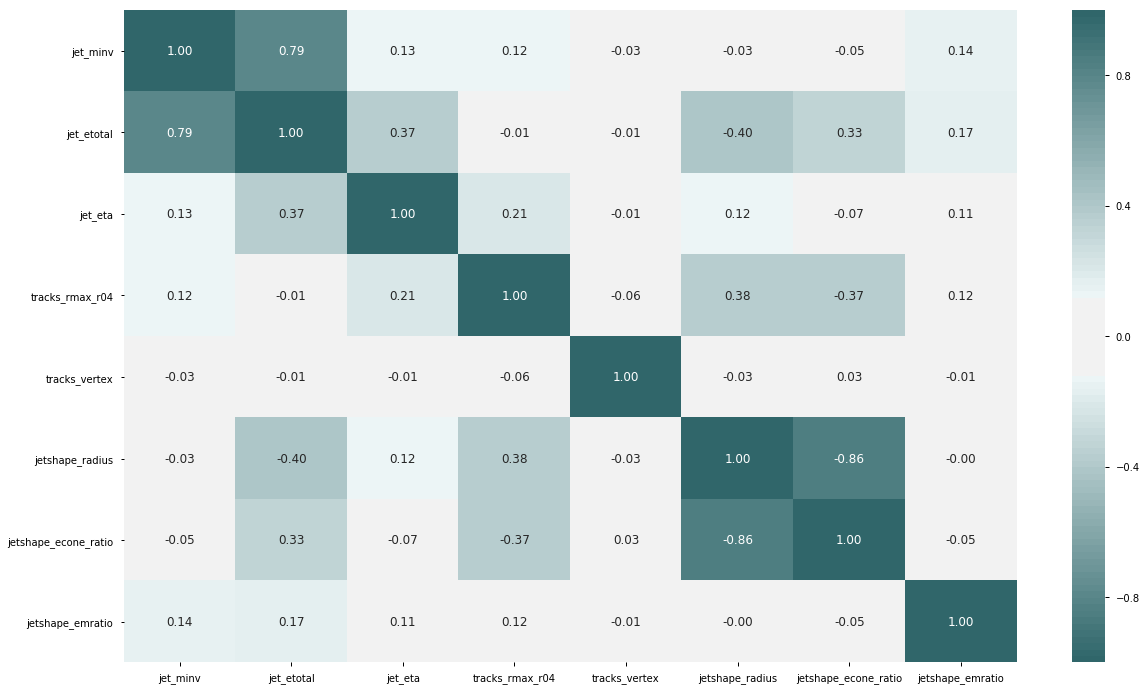

In [17]:
# display correlation parameters for pairs of paramter as heatmap
with sns.plotting_context("notebook", font_scale=1.0 ):
    fig = plt.figure(figsize=(20, 12))
    ax = sns.heatmap(df_select[feature_cols].corr(),
                     vmin=-1,vmax=1,annot=True, fmt=".2f", cmap=sns.diverging_palette(200, 200, l=40, sep=30, n=100))
    ax.set(xlabel='', ylabel='')
    plt.show()

The correlations between most selected feature columns are small. The mean jet radius (jetshape_radius) and the ratio of energy within a small cone within the jet divided by the total jet energy (jetshape_econe_ratio) have a correlation factor of -0.86. A correlation between these observables is expected because a smaller energy fraction in the center of the jet (small jetshape_econe_ratio) leads to a broader radial distribution of the jet energy and therefore a larger mean jet radius (jetshape_radius). The jet invariant mass (jet_minv) and total jet energy (jet_etotal) are correlated as well. This is also expected becuse the jet energy is used for the calculation of the jet invariant mass.

### Model selection

Load additional libraries for models and functions for model evaluation:

In [18]:
# load additional libraries
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import cross_val_predict, KFold

/usr/local/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In order to quickly test various models to see which one may perform best, we define a function that does such a quick evaluation. Then, we create an array with several models and their descriptions. We loop over the array to test all the included models.

Define a function to easily test a classifier and print model performance parameters:

In [19]:
# define function to quickly evaluate model
def test_model( model, features, target, kfold ):
      
    # use cross_val_predict for prediction
    predictions = cross_val_predict(model, features, target, cv=kfold)

    # False positives.
    fp_filter = (predictions == 1) & (target == 0)
    fp = len(df_train[fp_filter])

    # True positives.
    tp_filter = (predictions == 1) & (target == 1)
    tp = len(df_train[tp_filter])

    # False negatives.
    fn_filter = (predictions == 0) & (target == 1)
    fn = len(df_train[fn_filter])

    # True negatives
    tn_filter = (predictions == 0) & (target == 0)
    tn = len(df_train[tn_filter])

    # Rates
    tpr = tp / (tp + fn)
    fpr = fp / (fp + tn)

    # Fractions
    tp_frac = tp / len( target[ target == 1] )
    fp_frac = fp / len( target[ target == 0] )
    
    #print( "True positive fraction: %.2f percent" % (100*tp_frac))
    #print( "False positive fraction: %.2f percent" % (100*fp_frac))
    #print( "True positive: "+str(tp))
    #print( "True negativee: "+str(tn))
    #print( "False positive: "+str(fp))
    #print( "False negative: "+str(fn))
    #print( "True Positive Rate: "+str(tpr) )
    #print( "False Positive Rate: "+str(fpr) )
    
    #return true positive and false positive fractions
    return(tp_frac,fp_frac)

Create array of models to test:

In [20]:
# create array of models and their names / descriptions to quickly loop over them
models = []

# Decision tre classifier
models.append(('Decision Tree', DecisionTreeClassifier()))

# Decision tree classifier with penalties and maximum depth
penalty = {
    0: 1,
    1: 10
}
maxdepth = 10
models.append(("DecisionTree with Penalties (%d, %d) and Max Depth (%d)" % (penalty[0],penalty[1],maxdepth),
               DecisionTreeClassifier(class_weight=penalty, max_depth=maxdepth) ))

# Decision tree classifier with penalties and maximum depth
penalty = {
    0: 10,
    1: 1
}
maxdepth = 10
models.append(("DecisionTree with Penalties (%d, %d) and Max Depth (%d)" % (penalty[0],penalty[1],maxdepth),
               DecisionTreeClassifier(class_weight=penalty, max_depth=maxdepth) ))

# AdaBoost Classifier
models.append(("AdaBoost", AdaBoostClassifier(random_state=1) ))

# RandomForest Classifier
penalty = {
    0: 10,
    1: 1
}
models.append(("RandomForest with Penalties (%d, %d)" % (penalty[0],penalty[1]),
               RandomForestClassifier(class_weight=penalty, random_state=1) ))

### Cross-validation of selected models
Create subsets of training data with feature and target columns. Create a KFold for cross-validation.

In [21]:
# create subsets of training data with feature and target columns
features = df_train[ feature_cols ]
target = df_train[ target_col ]

# create KFold for cross-validation
kf = KFold(features.shape[0], shuffle=True, random_state=1)

Loop over models defined in array and see how they perform:

In [22]:
# evaluate each model in turn
for name, model in models:
    print( "Testing model: ", name )
    (tpf, fpf) = test_model( model, features, target, kf )
    print( "True positive fraction: %.2f percent" % (100*tpf))
    print( "False positive fraction: %.2f percent" % (100*fpf))
    print( "------------------------------------------------------------------------------------" )

Testing model:  Decision Tree
True positive fraction: 94.73 percent
False positive fraction: 10.00 percent
------------------------------------------------------------------------------------
Testing model:  DecisionTree with Penalties (1, 10) and Max Depth (10)
True positive fraction: 97.30 percent
False positive fraction: 14.63 percent
------------------------------------------------------------------------------------
Testing model:  DecisionTree with Penalties (10, 1) and Max Depth (10)
True positive fraction: 91.07 percent
False positive fraction: 4.75 percent
------------------------------------------------------------------------------------
Testing model:  AdaBoost
True positive fraction: 95.71 percent
False positive fraction: 6.34 percent
------------------------------------------------------------------------------------
Testing model:  RandomForest with Penalties (10, 1)
True positive fraction: 95.68 percent
False positive fraction: 5.84 percent
-----------------------------

###  Hyperparameter optimization

The DecisionTree classifier with penalties and maximum depth allows to optimize these parameters for the task of minimizing false positives while maximizing true positives in the tau classification.

In [23]:
# create array of models and their names / descriptions to quickly loop over them
trees_var_depth = []

# create array of tree depths to test
tree_depths = np.arange(1,100)

# Decision tree classifier with penalties and maximum depth
penalty = {
    0: 10,
    1: 1
}

# loop over various max_depth values and add decision trees with those values to array
for maxdepth in tree_depths:
    trees_var_depth.append(("Decision Tree with Penalties (%d, %d) and Max Depth (%d)" % (penalty[0],penalty[1],maxdepth),
                            DecisionTreeClassifier(class_weight=penalty, max_depth=maxdepth) ))

Loop over DecisionTree classifiers with different max_depth settings and collect the performance indicators in arrays. Plot the true positive rates and false positive rates as function of the max_depth model parameter.

In [24]:
# arrays to store true positive and false positive fractions
tree_vardepth_tp = []
tree_vardepth_fp = []

# evaluate each model in turn
for name, model in trees_var_depth:
    (tp,fp) = test_model( model, features, target, kf )
    tree_vardepth_tp.append( tp )
    tree_vardepth_fp.append( fp )

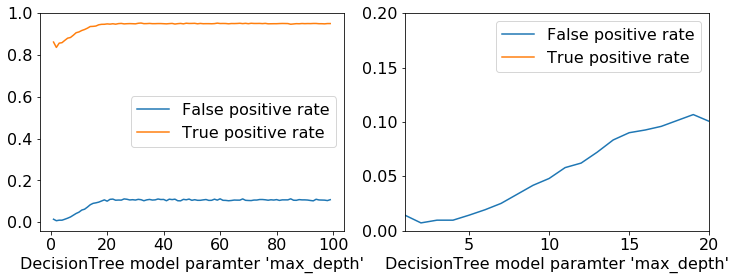

In [25]:
# plot true positive rate and false positive rate as function of chosen max_depth of decision tree
plt.figure(figsize=(12,4))

ax = plt.subplot(1,2,1)
plt.plot(tree_depths, tree_vardepth_fp, label='False positive rate')
plt.plot(tree_depths, tree_vardepth_tp, label='True positive rate')
plt.legend(loc='best')
ax.set_xlabel('DecisionTree model paramter \'max_depth\'')

ax = plt.subplot(1,2,2)
plt.plot(tree_depths, tree_vardepth_fp, label='False positive rate')
plt.plot(tree_depths, tree_vardepth_tp, label='True positive rate')
plt.legend(loc='best')
ax.set_xlabel('DecisionTree model paramter \'max_depth\'')
ax.set_xlim([1,20])
ax.set_ylim([0,0.2])

plt.show()

Both the false positive and true positive rates increases with increasing max_depth parameter of the DecisionTree model. At around max_depth=20 the rates reach a plateau. The close-up view of the false positive rates at low values of max_depth shown on the right shows an increase in false positives after max_depth=5. We choose max_depth=5 for the decision tree model.

Loop over DecisionTree classifiers with different penalty settings and collect the performance indicators in arrays. Plot the true positive rates and false positive rates as function of the penalty(1) model parameter.

In [26]:
# create array of models and their names / descriptions to quickly loop over them
trees_var_penalty = []

# create array of tree depths to test
#tree_penalties = [10**x for x in np.arange(0,100)]
tree_penalties = np.arange(1,100)

# choose maxdepth
maxdepth=5

# loop over various max_depth values and add decision trees with those values to array
for penalty in tree_penalties:
    
    penalty = {
        0: penalty,
        1: 1
    }
    
    trees_var_penalty.append(("Decision Tree with Penalties (%d, %d) and Max Depth (%d)" % (penalty[0],penalty[1],maxdepth),
                            DecisionTreeClassifier(class_weight=penalty, max_depth=maxdepth) ))
    
# arrays to store true positive and false positive fractions
tree_varpenalty_tp = []
tree_varpenalty_fp = []

# evaluate each model in turn
for name, model in trees_var_penalty:
    (tp,fp) = test_model( model, features, target, kf )
    tree_varpenalty_tp.append( tp )
    tree_varpenalty_fp.append( fp )

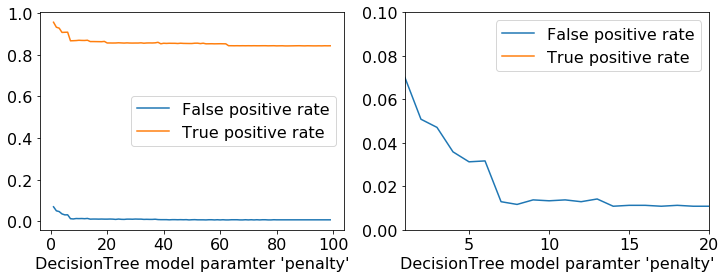

In [27]:
# plot true positive rate and false positive rate as function of chosen penalty of decision tree
plt.figure(figsize=(12,4))

ax = plt.subplot(1,2,1)
plt.plot(tree_penalties, tree_varpenalty_fp, label='False positive rate')
plt.plot(tree_penalties, tree_varpenalty_tp, label='True positive rate')
plt.legend(loc='best')
#ax.set_xscale("log", nonposx='clip')
ax.set_xlabel('DecisionTree model paramter \'penalty\'')

ax = plt.subplot(1,2,2)
plt.plot(tree_penalties, tree_varpenalty_fp, label='False positive rate')
plt.plot(tree_penalties, tree_varpenalty_tp, label='True positive rate')
plt.legend(loc='best')
#ax.set_xscale("log", nonposx='clip')
ax.set_xlabel('DecisionTree model paramter \'penalty\'')
ax.set_xlim([1,20])
ax.set_ylim([0,0.1])

plt.show()

Both the true positive and flase positive rates falls with increasing penalty for false positives. The false positive rate reaches its lowest value around penalty = 7. The right plot shows a cole-up view of the left plot the false positive rate at low penalty values. We choose penalty=7 for the Decision Tree model.

Test the DecisionTree model with the optimized parameters:

In [28]:
# Decision tree classifier with penalties and maximum depth
penalty = {
    0: 7,
    1: 1
}
maxdepth = 5
model_opt = DecisionTreeClassifier(class_weight=penalty, max_depth=maxdepth)

(tpf, fpf) = test_model( model_opt, features, target, kf )
print( "True positive fraction: %.2f percent" % (100*tpf))
print( "False positive fraction: %.2f percent" % (100*fpf))

True positive fraction: 86.71 percent
False positive fraction: 1.29 percent


The false positive rate of the DecisionTree model with optimized hyperparameters is lower than the value we got with our initially chosen parameters. The true positive rate drops less.

# 5 Evaluating algorithm for tau jet classification

Create a fresh copy of the DecisionTree model with the optimized hyperparameters from the previous step, train it on the train data sample, and see how it performs on the test data sample (which we have not used so far in the model training and evaluation).

In [29]:
# Decision tree classifier with penalties and maximum depth
penalty = {
    0: 7,
    1: 1
}
maxdepth = 5
model_opt = DecisionTreeClassifier(class_weight=penalty, max_depth=maxdepth)

# train on training data
model_opt.fit( features, target )

# create subsets of features and target values from test data
test_features = df_test[ feature_cols ]
test_target = df_test[ target_col ]

# make predictions for test data
predictions = model_opt.predict( test_features )

# determine true positives and false positives for predictions on test data
tp = len( df_test[ (predictions == 1) & (df_test["signal"] == 1) ] )
fp = len( df_test[ (predictions == 1) & (df_test["signal"] == 0) ] )

# Fractions
tp_frac = tp / len( test_target[ test_target == 1] )
fp_frac = fp / len( test_target[ test_target == 0] )

print( "True positive fraction: %.2f percent" % (100*tp_frac))
print( "False positive fraction: %.2f percent" % (100*fp_frac)) 

True positive fraction: 85.89 percent
False positive fraction: 1.04 percent


Using our model to predict the signal (tau) and background (hadron) jets in the test sample yields comparable true positive and false positive fractions as the cross-validation result on the training data itself from the previous section. This indicates that our model is robust and has not been overtrained on the training data.

# 6 Conclusion

The cut-based selection yields 0.2% false positives fraction at 46% true positives fraction. The DecisionTree model yields 1% false positives fraction at 86% true positives fraction.

Neither of these methods could reliably identify a single tau jet in a background of over 100 million hadron jets. However, in an analysis of EIC data, the tau identification is only one step of the overall event classification. In addition to finding a tau candidate, analyzing overall event topologies will help to furhter reduce misidentifications of Standard Model background events as 'Beyond the Standard Model' electron-to-tau conversion events.

Moreover, the design of the experiment and development of reconstruction algorithms are still evolving. By the time the EIC actually starts operating, the capabilities of the experiment itself to measure charged tracks and jets may have significantly improved, which would lead to a better quality of input data for tau identification.

# Next steps
* Try different combinations of selected feature columns to improve the tau classification.
* Normalize the data to a common range. This might help in training the machine learning algorithms.
* Try hyperparameter optimization for the RandomForest classifier.
* Try different machine learning algorithms.
* Simulate larger data samples. These will be necessary to fully evaluate the tau selection and rejection of background events that are 100 million times more frequent than signal events.
* Improve the quality of the input data by improving the reconstruction of tracks and jets in the experiment.
* Reconstruct full event kinematics in addition to individual jets and evaluate the efficiencies to separate electron-to-tau conversion events from Standard Model background events.